In [1]:
import os
os.chdir('../')

In [2]:
from data_struct import scData
from ana_utils import *
from sim_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
%matplotlib inline
from gene_expr import *

In [3]:
from itertools import product
from scipy.stats import nbinom
from inference import velocity_inference
from embedding import velocity_embedding
from matplotlib_venn import venn3

/home/wangkun/LineageTracingwithscRNA/inference.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
# tree_file = 'tree_origin_var0.02_rvg0.05.csv0'
# reconstruct('../datas/line_model/'+tree_file, output='../datas/line_model/'+tree_file+'.nwk', num=1000, is_balance=True)

In [6]:
tree_file = '../datas/line_model/tree_origin_var0.02_rvg0.05.csv0.nwk'

In [7]:
phylo_tree, branch_colors = loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
# fig, ax = plt.subplots(figsize=(10,20))
# plot_tree(phylo_tree, branch_colors, ax=ax, stain='terminals')

In [8]:
cell_names, cell_states, cell_generation = get_annotation('../datas/line_model/tree_origin_var0.02_rvg0.05.csv0')

In [9]:
cell_states = pd.DataFrame(data=cell_states, index=cell_names)
cell_states = cell_states.loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names)
cell_generation = cell_generation.loc[sampled_cells]
cell_generation = cell_generation.to_numpy()

In [10]:
sd = scData(phylo_tree=phylo_tree, 
            cell_states=cell_states.to_numpy().T[0].astype('int'), 
            cell_generation=cell_generation.T[0].astype('int'),
            cell_names=sampled_cells)

In [21]:
ge, base_expr = sim_base_expr(sd.phylo_tree, 
                                 cell_states,
                                 Ngene=2000, 
                                 r_variant_gene=0.4, 
                                 variance=0.01, 
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0, 
                                 mu0_scale=1, 
                                 drift_loc=0, 
                                 drift_scale=0.3,
                                )

/home/wangkun/LineageTracingwithscRNA/sim_utils.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(cellstate, int(terminals_depths[cell]) - t0 - start_time[cellstate] + pseudo_start_time[cellstate])


In [22]:
# with open('/raid/wangkun/results_sd/simulation_linear.pkl', 'rb') as f:
#     sd = pickle.load(f)

In [23]:
sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

In [30]:
sd.dimensionality_reduction(methor='tsne', scale=10, n_highly_variable_genes=0, perplexity=30, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


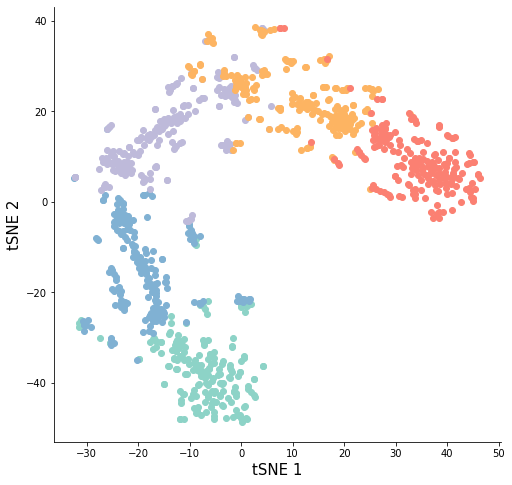

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/tsne.pdf', dpi='figure', format='pdf')

In [32]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [82]:
sd = velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)

/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)


In [83]:
sd = velocity_embedding(sd, target='count')

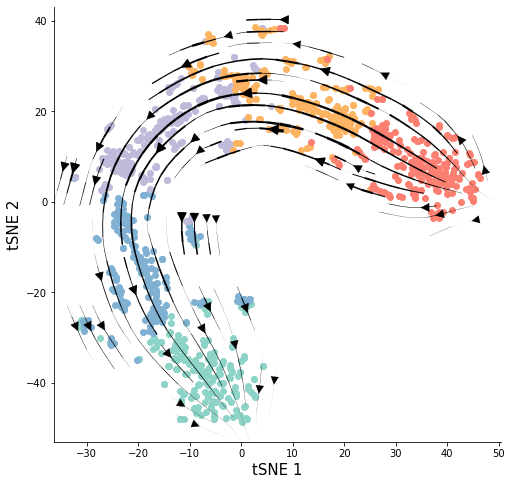

In [87]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/stream.pdf', dpi='figure', format='pdf')

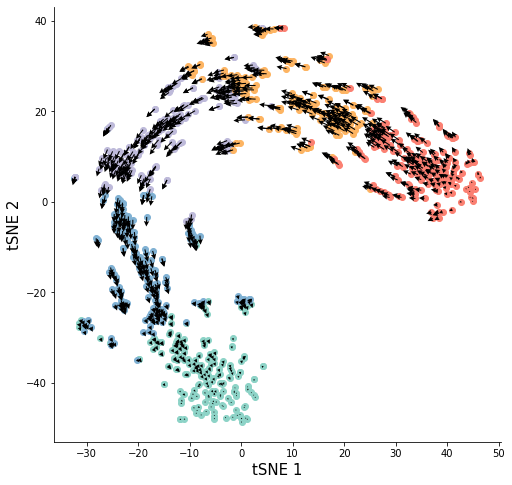

In [85]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point',streamdensity=1, radius=5, lw_coef=500,headwidth=5)
ax.figure.set_size_inches(8,8)
# ax.set_title('Branch model', fontsize=15)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/quiver.pdf', dpi='figure', format='pdf')

In [115]:
from matplotlib_venn import venn3

In [36]:
drifts = pd.DataFrame(data=np.array([np.array([ge.cells[ct][g].drift for ct in range(5)]) for g in range(2000)]), index=range(2000))
megs = set(np.arange(2000)[drifts.apply(lambda x: np.all(x<0) or np.any([np.all(x[:i]<0)&np.all(x[i:]>0) for i in range(5)]), axis=1)])

In [103]:
from scipy.stats import spearmanr
megs0 = set()
for i in megs:
    try:
        if abs(spearmanr(sd.count[i], sd.cell_generation)[0]) > 0.4:
            megs0.add(i)
    except:
        None

In [104]:
from scipy.stats import mannwhitneyu, spearmanr

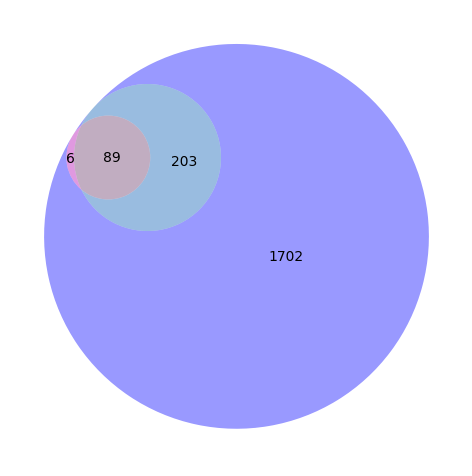

In [105]:
plt.figure(figsize=(6,6), dpi=100)
genesets = [set(sd.clock_genes), megs0, set(range(2000))]
g = venn3(subsets=genesets, 
          set_labels=(' ', ' ', ' '))

plt.savefig('./figures/Linear/venn.pdf', format='pdf')

In [45]:
import pickle
with open('/raid/wangkun/results_sd/simulation_linear.pkl', 'wb') as f:
    pickle.dump(sd, f)

In [78]:
mutation_tree = deepcopy(sd.phylo_tree)
mut_rate = 1
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)

depths1 = np.array([mutation_tree.depths()[mutation_tree.find_any(name=i)] for i in sd.count.index])

In [79]:
sd = velocity_inference(sd, depths1, cutoff=0.9, target='count', exact=True)
sd = velocity_embedding(sd, target='count')

/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)


mu=1


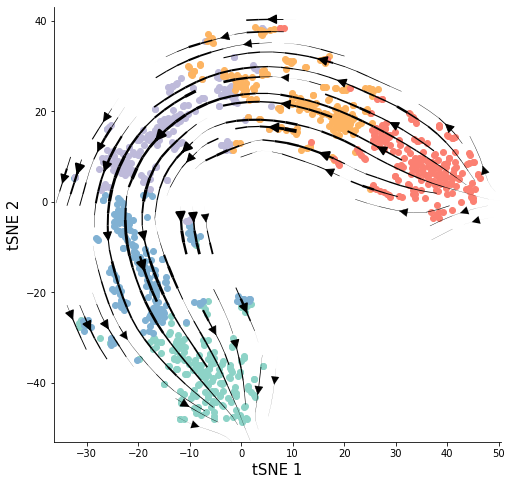

In [80]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=1')

mu=0.3


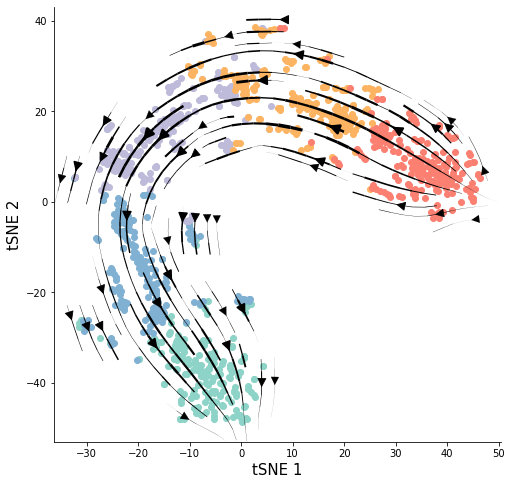

In [70]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=0.3')

mu=0.1


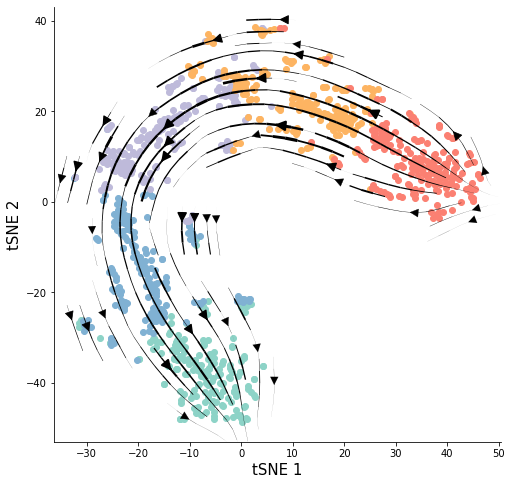

In [77]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=0.1')

In [124]:
cell_type_map = dict(zip([branch_colors[i][:-2] for i in range(len(branch_colors))], [branch_colors[i][-1] for i in range(len(branch_colors))]))

In [205]:
import anndata
import scvelo as scv

In [307]:
from scipy.stats import beta
us_log = dict()
Ngene = 2000
# alpha, beta, gamma = beta(2,20).rvs(Ngene), beta(2,20).rvs(Ngene), beta(2,20).rvs(Ngene)
alpha, beta, gamma = 0.1, 0.1, 0.1
for i in sd.phylo_tree.get_terminals(): 
    for node in sd.phylo_tree.get_path(i):
        if node.name in us_log:
            u, s = us_log[node.name]
            
        else:
            if re.findall('[0-9]+', node.name)[0] == '1': 
                u, s = np.array([10]*Ngene), np.array([10]*Ngene)
                us_log[node.name] = (u, s)
            else:
                di = drifts[int(cell_type_map[i.name])]
                u, s = np.array(alpha*(di>0) + (1-beta)*u), np.array(beta*u+(1-gamma)*s)
                us_log[node.name] = (u, s)

In [321]:
u, s = dict(), dict()
for i in sd.count.index:
    ui, si = us_log[i][0][sd.count.columns], us_log[i][1][sd.count.columns]
    ui, si = ui/(ui+si), si/(ui+si)
    u[i] = sd.count.loc[i]*ui
    s[i] = sd.count.loc[i]*si

In [357]:
mutation_tree = deepcopy(sd.phylo_tree)
mut_rate = 0.1
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)

In [358]:
Phylo.write(mutation_tree, 'linear_0.1', format='newick')

1

In [449]:
import seaborn as sns
from sklearn.preprocessing import scale

def expr_sort(gene, states):
    expr = []
    for state in states:
        t = list(ge.expr_rec[state].keys())
        t.sort()
        expr.append([ge.expr_rec[state][i][gene] for i in t])
    return sum(expr, [])

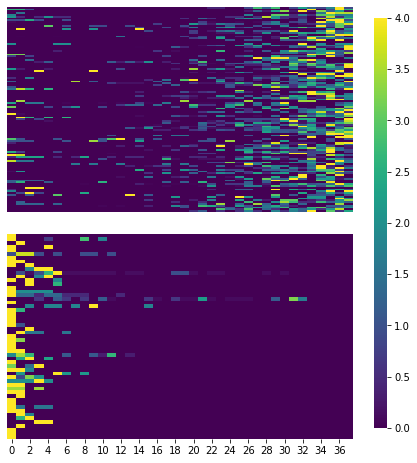

In [522]:
fig = plt.figure(figsize=(6, 6))
h1 = 0.5
h2 = 0.5
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]<0]])
# expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax1 = sns.heatmap(expr_mat[expr_mat.sum(axis=1)!=0], cmap='viridis', ax=ax1, vmax=4, vmin=0, cbar_ax=ax3, yticklabels='')
n1 = sum(expr_mat.sum(axis=1)!=0)

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]>0]])
expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax2 = sns.heatmap(expr_mat.sample(169-n1), cmap='viridis', ax=ax2, cbar=False, vmax=3, vmin=0, xticklabels=False, yticklabels='')

In [631]:
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']

In [642]:
import seaborn as sns

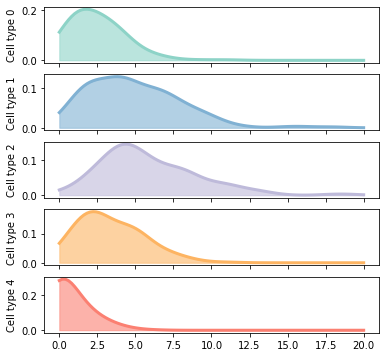

In [832]:
fig, ax = plt.subplots(5, 1, figsize=(6, 6), sharex=True)
g = 99
from sklearn.neighbors import KernelDensity
for i in range(5):  
    ax[i].set_ylabel(f'Cell type {i}', fontsize=10)
    data_kde = sd.count[g][sd.cell_states==i].to_numpy()
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(data_kde[:, np.newaxis])
    x_kde = np.linspace(0,20,100)
    y_kde = np.exp(kde.score_samples(x_kde[:, np.newaxis]))
    ax[i].plot(x_kde, y_kde, c=cmps[i], lw=3)
    ax[i].fill_between(x_kde, y_kde, color=cmps[i], alpha=0.6)
    # ax[i].vlines(np.mean(data_kde), 0, np.exp(kde.score_samples([[np.mean(data_kde)]])), color='black', lw=2)
    
# ax[i].set_xlabel(f'Cell', fontsize=15)

In [839]:
model = 'linear'
from scipy.stats import zscore
sd.count.to_csv(f'{model}_cnt.csv')
sd.normalize_filter()
sd.x_normed.to_csv(f'{model}_norm.csv')
zscore(sd.x_normed).to_csv(f'{model}_zscore.csv')

In [888]:
from copy import deepcopy

In [895]:
tree, branch_colors = loadtree(tree_file)
mutations = dict()
global_mutid = 0

In [917]:
mu = 0.3
for i in tree.get_terminals():
    mut = []
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            for _ in range(np.random.poisson(mu)):
                mut.append(global_mutid+1)
                global_mutid += 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    seq = np.zeros(global_mutid+1)
    seq[mutations[i.name]]=1
    mut_table.append(seq)
    cell_nemes.append(i.name)

In [924]:
mut_table = pd.DataFrame(data=mut_table, index=cell_nemes).iloc[:,1:]
mut_table.astype('int').to_csv('Linear.csv')

In [1033]:
from Bio import Phylo
tree = Phylo.read('../datas/NJ&ML/Linear_tree_nj_rescale.nwk', format='newick')
tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [np.round(depths_map[i[1:-1]]) for i in sd.count.index]

In [1034]:
sd = velocity_inference(sd, depths, target='count', exact=True)
sd = velocity_embedding(sd, target='x_normed', n_neigh=300)
dir_nj = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

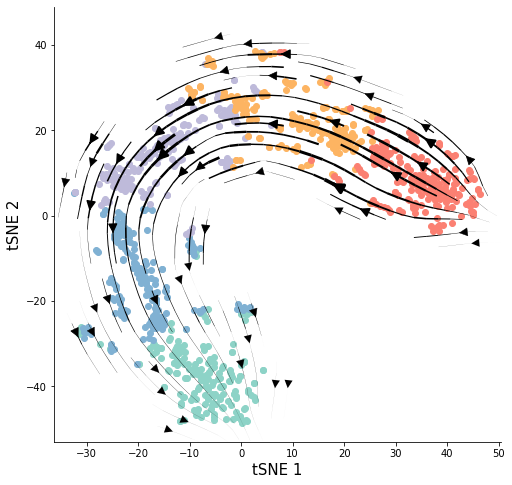

In [1035]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=20, radius=4, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)

In [1036]:
from Bio import Phylo
tree = Phylo.read('../datas/NJ&ML/Linear_tree_ML_rescale.nwk', format='newick')
tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [np.round(depths_map[i[1:-1]]) for i in sd.count.index]

In [1038]:
sd = velocity_inference(sd, depths, target='count', exact=True)
sd = velocity_embedding(sd, target='x_normed', n_neigh=300)
dir_ml = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

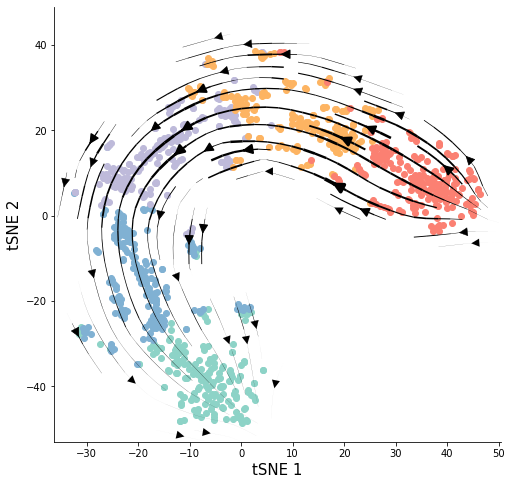

In [1039]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=20, radius=4, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)

In [1042]:
from Bio import Phylo
tree = Phylo.read('../datas/NJ&ML/linear_muts_MP_rooted.nwk', format='newick')
tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [np.round(depths_map[i[1:-1]]) for i in sd.count.index]

In [1043]:
sd = velocity_inference(sd, depths, target='count', exact=True)
sd = velocity_embedding(sd, target='x_normed', n_neigh=300)
dir_mp = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

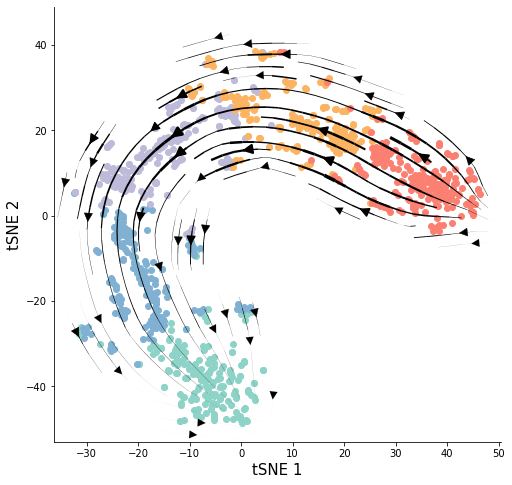

In [1044]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=20, radius=4, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)

In [1047]:
sd = velocity_inference(sd, sd.cell_generation, target='count', exact=True)
sd = velocity_embedding(sd, target='x_normed', n_neigh=300)
dir_gt = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

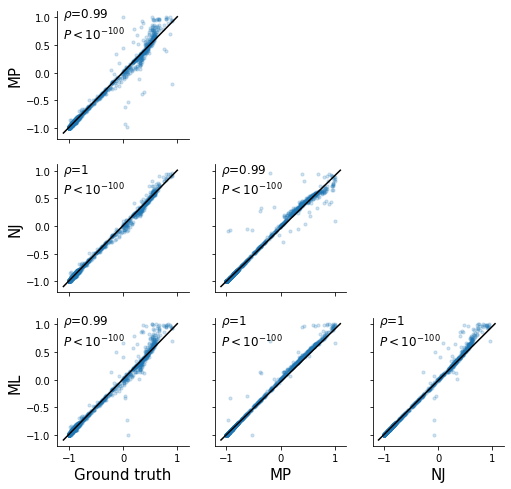

In [1073]:
dirs = [dir_gt, dir_mp, dir_nj, dir_ml]
labels = ['Ground truth', 'MP', 'NJ', 'ML']

from scipy.stats import spearmanr

fig, ax = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)
for i in range(1, 4):
    for j in range(i):
        x, y = dirs[j], dirs[i]
        
        ax[i-1][j].scatter(x, y, alpha=0.2, s=10)
        ax[i-1][j].plot(np.linspace(min(x)*1.1,max(x)*1.1,60), y_est, '-', c='k')
        if i == 3:
            ax[i-1][j].set_xlabel(labels[j], fontsize=15)
        if j == 0:
            ax[i-1][j].set_ylabel(labels[i], fontsize=15)
        rho, pval = spearmanr(x, y)
        ax[i-1][j].text(min(x)*1.1, max(y), r"$\rho$={:.2g}".format(rho), fontsize=12)

        ax[i-1][j].text(min(x)*1.1, max(y)*0.6, r"$P<10^{-100}$", fontsize=12)
        ax[i-1][j].spines['right'].set_visible(False)
        ax[i-1][j].spines['top'].set_visible(False)
        
for i in range(2):
    for j in range(i+1, 3):
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False) 
        ax[i][j].spines['bottom'].set_visible(False) 
        ax[i][j].spines['left'].set_visible(False) 
        ax[i][j].axes.xaxis.set_visible(False)
        ax[i][j].axes.yaxis.set_visible(False)


In [1081]:
pd.DataFrasd.cell_states

array([2, 0, 2, 2, 1, 4, 2, 2, 4, 0, 2, 2, 1, 0, 3, 1, 0, 0, 1, 4, 0, 2,
       0, 3, 3, 3, 4, 1, 1, 1, 2, 2, 2, 3, 2, 3, 3, 2, 3, 1, 2, 2, 0, 0,
       2, 1, 0, 3, 1, 0, 4, 2, 3, 2, 4, 4, 2, 4, 0, 1, 4, 2, 3, 3, 3, 3,
       3, 3, 3, 4, 0, 4, 3, 3, 1, 4, 0, 4, 4, 0, 0, 3, 3, 1, 0, 1, 1, 2,
       1, 4, 3, 0, 3, 1, 4, 3, 3, 3, 4, 1, 0, 2, 2, 3, 3, 0, 0, 2, 3, 4,
       0, 0, 3, 1, 4, 0, 1, 2, 0, 1, 0, 1, 1, 1, 3, 3, 2, 3, 1, 1, 0, 3,
       1, 3, 0, 3, 1, 2, 2, 4, 4, 3, 4, 4, 3, 3, 2, 3, 4, 3, 0, 1, 4, 2,
       4, 3, 4, 3, 4, 4, 0, 1, 3, 0, 2, 0, 0, 1, 3, 0, 1, 4, 0, 1, 4, 1,
       0, 1, 2, 4, 0, 2, 1, 2, 2, 3, 0, 3, 1, 1, 1, 4, 4, 2, 1, 1, 3, 2,
       0, 2, 0, 3, 4, 4, 2, 4, 2, 3, 4, 4, 2, 0, 4, 1, 1, 3, 3, 2, 3, 0,
       4, 1, 2, 4, 2, 0, 2, 1, 3, 4, 2, 2, 2, 2, 4, 2, 4, 3, 0, 1, 1, 3,
       0, 0, 0, 4, 4, 1, 4, 0, 3, 2, 1, 1, 0, 4, 0, 2, 0, 0, 3, 4, 1, 1,
       2, 3, 0, 0, 1, 2, 3, 0, 1, 1, 0, 0, 3, 2, 1, 0, 1, 4, 0, 2, 2, 1,
       2, 1, 0, 1, 2, 1, 2, 3, 2, 3, 2, 4, 0, 0, 2,